In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
df = pd.read_csv('data/faers_filtered_adalimumab_2020-2024_grouped.csv')

In [3]:
df.isna().sum() / len(df) * 100

primaryid       0.000000
caseid          0.000000
caseversion     0.000000
event_dt       60.442913
init_fda_dt     0.000000
fda_dt          0.000000
age            41.963818
age_cod        41.963498
age_grp        88.897394
sex            11.049600
wt             69.829788
wt_cod         69.829788
rept_dt         0.003843
occp_cod        2.431232
seq             0.000000
role_cod        0.000000
drugname        0.000000
prod_ai         0.000000
route           7.668262
dose_vbm       42.888622
dose_amt       51.635581
dose_unit      49.562740
dose_form      31.233536
dose_freq      76.679899
indi_pt        29.183755
outc_cod       20.976304
pt              0.000000
start_dt       68.656609
end_dt         87.989565
dtype: float64

In [4]:
# Drop 'event_dt', 'wt', 'wt_cod', 'start_dt', 'end_dt' columns
data = df.drop(columns=['event_dt', 'wt', 'wt_cod', 'start_dt', 'end_dt'])

In [5]:
# Lowercase 
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [6]:
# Check for duplicates
data.duplicated().sum()

np.int64(554)

In [7]:
# Drop duplicates
data = data.drop_duplicates()

In [8]:
data['primaryid'].nunique(), data['caseid'].nunique()

(299225, 257274)

In [9]:
pd.set_option('display.max_columns', None)

# Display the first 5 rows
data.head(5)

,primaryid,caseid,caseversion,init_fda_dt,fda_dt,age,age_cod,age_grp,sex,rept_dt,occp_cod,seq,role_cod,drugname,prod_ai,route,dose_vbm,dose_amt,dose_unit,dose_form,dose_freq,indi_pt,outc_cod,pt
0,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,1,ps,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection in pre-filled syringe,qow,rheumatoid arthritis,ot,"['arterial occlusive disease', 'carotid artery..."
1,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,1,ps,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection in pre-filled syringe,qow,rheumatoid arthritis,ho,"['arterial occlusive disease', 'carotid artery..."
2,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,2,ss,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection,qow,NaN,ot,"['arterial occlusive disease', 'carotid artery..."
3,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,2,ss,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection,qow,NaN,ho,"['arterial occlusive disease', 'carotid artery..."
4,102775337,10277533,7,20140703,20200124,40.0,yr,NaN,m,20200124.0,md,1,ps,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection,qow,crohn's disease,ho,"['anal incontinence', 'constipation', 'defaeca..."


### 1. Missing values in indi_pt, dose_form, dose_amt, dose_unit, dose_freq

In [10]:
# Drop all missing values in 'indi_pt' column
indi_pt_missing = data.loc[data['indi_pt'].isnull() | 
                             (data['indi_pt'] == 'product used for unknown indication')]

mask = data.isin(indi_pt_missing.to_dict(orient='list')).all(axis=1)
data_2 = data[~mask]

In [11]:
# Drop all missing dosage values
dose_missing = data_2.loc[
    ((data_2['dose_form'] == 'unknown') | data_2['dose_form'].isna()) & 
    data_2[['dose_amt', 'dose_unit', 'dose_freq']].isna().all(axis=1)
]
mask = data_2.isin(dose_missing.to_dict(orient='list')).all(axis=1)
data_3 = data_2[~mask]

### 2. Date in init_fda_dt, fda_dt, rept_dt

In [12]:
# Convert 'init_fda_dt' and 'fda_dt' to datetime
data_3['init_fda_dt'] = pd.to_datetime(data_3['init_fda_dt'].astype(str), format='%Y%m%d')
data_3['init_fda_dt'] = data_3['init_fda_dt'].dt.strftime('%Y-%m-%d')

data_3['fda_dt'] = pd.to_datetime(data_3['fda_dt'].astype(str), format='%Y%m%d')
data_3['fda_dt'] = data_3['fda_dt'].dt.strftime('%Y-%m-%d')

data_3['rept_dt'] = data_3['rept_dt'].astype(str).str.replace(r'\.0$', '', regex=True) # Remove trailing .0
data_3['rept_dt'] = pd.to_datetime(data_3['rept_dt'].astype(str), format='%Y%m%d', errors='coerce')
data_3['rept_dt'] = data_3['rept_dt'].dt.strftime('%Y-%m-%d')

In [13]:
# Replace missing dates in 'rept_dt' with 'fda_dt'
data_3['rept_dt'] = data_3['rept_dt'].fillna(data_3['fda_dt'])

### 3. Missing values in occp_cod, sex, outc_cod

In [14]:
# Function to replace 'unk' values with the ratio of the remaining values
def replace_unk(data, column, unknown='unk'):
    # Fill missing values with value
    data[column] = data[column].fillna(unknown)

    # Count
    val_count = data[column].value_counts()
    unk_count = val_count[unknown]
    val_count = val_count.drop(unknown)
    val_ratio = val_count / val_count.sum()

    # Replace 'unk' values with the ratio of the remaining values
    replacement_val = np.random.choice(val_ratio.index, size=unk_count, p=val_ratio.values)

    unk_index = data.loc[data[column] == unknown].index
    data.loc[unk_index, column] = replacement_val

    return data

In [15]:
data_3[['occp_cod', 'sex', 'outc_cod']].isna().sum() / len(data_3) * 100

occp_cod     3.957645
sex          8.255864
outc_cod    27.496066
dtype: float64

In [16]:
data_3['occp_cod'].value_counts()

occp_cod
cn    177697
hp     82485
md     34442
ph      2529
lw        76
Name: count, dtype: int64

In [17]:
# Fill missing values in the 'occp_cod' column
# data_3['occp_cod'] = data_3['occp_cod'].fillna('unk')

data_3 = replace_unk(data_3, 'occp_cod', 'unk')

In [18]:
data_3['sex'].value_counts()

sex
f      203200
m       80703
unk        24
Name: count, dtype: int64

In [19]:
# Fill missing values in the 'sex' column
# data_3['sex'] = data_3['sex'].fillna('unk')

data_3 = replace_unk(data_3, 'sex', 'unk')

In [20]:
data_3['outc_cod'].value_counts()

outc_cod
ot    119678
ho     59509
ds     16132
de     14763
lt     11404
ca      2714
ri       183
Name: count, dtype: int64

In [21]:
# Fill missing values in the 'outc_cod' column
data_3 = replace_unk(data_3, 'outc_cod', 'unk')

### 4. Drop contaminant and interacting in role_cod

In [22]:
# Drop 'c' and 'i' rows in role_cod
data_3 = data_3[~data_3['role_cod'].isin(['c', 'i'])]

### 5. Synchronize values in age, age_cod, age_grp

In [23]:
data_3[['age', 'age_cod', 'age_grp']].isna().sum() / len(data_3) * 100

age        44.021052
age_cod    44.020722
age_grp    92.141803
dtype: float64

In [24]:
data_3[['age', 'age_cod', 'age_grp']].head(5)

,age,age_cod,age_grp
0,55.0,yr,NaN
1,55.0,yr,NaN
4,40.0,yr,NaN
5,40.0,yr,NaN
11,NaN,NaN,NaN


In [25]:
age_list = ['age', 'age_cod', 'age_grp']
for col in age_list:
    print(data_3[col].value_counts())
    print()

age
44.0       16342
43.0       11378
40.0        7795
59.0        4935
63.0        4300
           ...  
20602.0        4
22728.0        2
100.0          1
16261.0        1
99.0           1
Name: count, Length: 107, dtype: int64

age_cod
yr     169795
dy         65
dec        62
mon        27
wk         21
hr          1
Name: count, dtype: int64

age_grp
a    18438
e     4422
t      461
c      308
n      198
i       33
Name: count, dtype: int64



In [26]:
# Convert age values to 'year'-based unit
conversion_age = {
    'dec': 10,
    'yr': 1,
    'mon': 1/12,
    'wk': 1/52,
    'dy': 1/365,
    'hr': 1/8760
}

data_3['age'] *= data_3['age_cod'].replace(conversion_age).astype(float)
data_3['age'] = data_3['age'].round(1)

In [27]:
# Fill missing values in the 'age_grp' column based on the 'age' column
def map_age_group(conversion_grp, age):

    for i in range(len(conversion_grp['min_yr'])):
        if conversion_grp['min_yr'][i] <= age < conversion_grp['max_yr'][i]:
            return conversion_grp['age_grp'][i]
        
    return None

conversion_grp = {
    'age_grp': ['n', 'i', 'c', 't', 'a', 'e'],
    'min_yr': [0.0, 0.1, 2.0, 12.0, 18.0, 65.0],
    'max_yr': [0.1, 2.0, 12.0, 18.0, 65.0, 120.0]
}

data_3['age_grp'] = data_3.apply(
    lambda row: map_age_group(conversion_grp, row['age']) if pd.notnull(row['age']) and pd.isnull(row['age_grp']) else row['age_grp'],
    axis=1
)

In [28]:
# Drop 'age_cod' column
data_3 = data_3.drop(columns='age_cod')

In [29]:
# Fill missing values in the 'age_grp' column
data_3 = replace_unk(data_3, 'age_grp', 'u')

In [30]:
def replace_rand_age(age_grp, conversion_grp):

    # Return a random age within the range of the age group
    for i in range(len(conversion_grp['age_grp'])):
        if conversion_grp['age_grp'][i] == age_grp:
            return round(np.random.uniform(conversion_grp['min_yr'][i], conversion_grp['max_yr'][i]), 1)

    return None

data_3['age'] = data_3.apply(
    lambda row: replace_rand_age(row['age_grp'], conversion_grp) if pd.isnull(row['age']) else row['age'],
    axis=1
)

### 6. Synchronize values in drugname, prod_ai

In [31]:
data_3['prod_ai'].value_counts()

prod_ai
adalimumab                                      275048
adalimumab\isopropyl alcohol                     13731
adalimumab-adaz                                   6703
adalimumab-afzb                                   3463
adalimumab-fkjp                                   2115
adalimumab-aaty                                   1133
adalimumab-ryvk                                    586
adalimumab-bwwd                                    398
adalimumab-atto                                    345
adalimumab-aqvh                                     49
adalimumab-aacf                                     40
adalimumab-adbm                                     16
adalimumab\adalimumab-aacf\isopropyl alcohol         5
Name: count, dtype: int64

In [32]:
data_3[data_3['prod_ai'] == 'adalimumab-adaz']['drugname'].value_counts()

drugname
hyrimoz            6690
adalimumab-adaz      13
Name: count, dtype: int64

In [33]:
data_3[data_3['prod_ai'] == 'adalimumab-afzb']['drugname'].value_counts()

drugname
abrilada    3463
Name: count, dtype: int64

In [34]:
data_3[data_3['prod_ai'] == 'adalimumab-fkjp']['drugname'].value_counts()

drugname
hulio              2113
adalimumab-fkjp       2
Name: count, dtype: int64

In [35]:
data_3[data_3['prod_ai'] == 'adalimumab-aaty']['drugname'].value_counts()

drugname
yuflyma            1047
adalimumab-aaty      86
Name: count, dtype: int64

In [36]:
data_3[data_3['prod_ai'] == 'adalimumab-ryvk']['drugname'].value_counts()

drugname
simlandi           584
adalimumab-ryvk      2
Name: count, dtype: int64

In [37]:
data_3[data_3['prod_ai'] == 'adalimumab-bwwd']['drugname'].value_counts()

drugname
hadlima            394
adalimumab-bwwd      4
Name: count, dtype: int64

In [38]:
data_3[data_3['prod_ai'] == 'adalimumab-atto']['drugname'].value_counts()

drugname
amjevita    345
Name: count, dtype: int64

In [39]:
data_3[data_3['prod_ai'] == 'adalimumab-aqvh']['drugname'].value_counts()

drugname
yusimry            32
adalimumab-aqvh    17
Name: count, dtype: int64

In [40]:
data_3[data_3['prod_ai'] == 'adalimumab-aacf']['drugname'].value_counts()

drugname
idacio             39
adalimumab-aacf     1
Name: count, dtype: int64

In [41]:
data_3[data_3['prod_ai'] == 'adalimumab-adbm']['drugname'].value_counts()

drugname
cyltezo            15
adalimumab-adbm     1
Name: count, dtype: int64

In [42]:
data_3[data_3['prod_ai'] == r'adalimumab\adalimumab-aacf\isopropyl alcohol']['drugname'].value_counts()

drugname
adalimumab-aacf    5
Name: count, dtype: int64

In [43]:
data_3[data_3['prod_ai'] == 'adalimumab\isopropyl alcohol']['drugname'].value_counts()

drugname
adalimumab    13731
Name: count, dtype: int64

In [44]:
# Replace the value drugname with its key
drugname = {
    'adalimumab-adaz': 'hyrimoz',
    'adalimumab-afzb': 'abrilada',
    'adalimumab-fkjp': 'hulio',
    'adalimumab-aaty': 'yuflyma',
    'adalimumab-ryvk': 'simlandi',
    'adalimumab-bwwd': 'hadlima',
    'adalimumab-atto': 'amjevita',
    'adalimumab-aqvh': 'yusimry',
    'adalimumab-aacf': 'idacio',
    'adalimumab-adbm': 'cyltezo',
    'humera': 'humira',
    'humira ac': 'humira'
}

data_3['drugname'] = data_3['drugname'].replace(drugname)

In [45]:
# Replace all values out of the druglist with 'adalimumab'
druglist = ['humira', 'hyrimoz', 'abrilada', 'imraldi', 'hulio', 
            'amgevita', 'yuflyma', 'simlandi', 'hadlima', 'amjevita', 
            'yusimry', 'idacio', 'cyltezo', 'solymbic', 'dalibra', 'adalimumab']

data_3['drugname'] = data_3['drugname'].apply(lambda x: x if x in druglist else 'adalimumab')

In [46]:
data_3[data_3['drugname'] == 'idacio']['prod_ai'].value_counts()

prod_ai
adalimumab-aacf                                 40
adalimumab\adalimumab-aacf\isopropyl alcohol     5
Name: count, dtype: int64

In [47]:
data_3[data_3['drugname'] == 'adalimumab']['prod_ai'].value_counts()

prod_ai
adalimumab                      24984
adalimumab\isopropyl alcohol    13731
Name: count, dtype: int64

In [48]:
# Replace the value prod_ai with its key
prod_ai_name = {
    r'adalimumab\adalimumab-aacf\isopropyl alcohol': 'adalimumab-aacf',
    'adalimumab\isopropyl alcohol': 'adalimumab'
}

data_3['prod_ai'] = data_3['prod_ai'].replace(drugname)

### 7. Missing values in route

In [49]:
data_3['route'].isna().sum() / len(data_3) * 100

np.float64(2.102215840227644)

In [50]:
data_3['route'].value_counts()

route
subcutaneous                             273080
unknown                                   18314
oral                                       1746
sunconjunctival                            1065
transplacental                              998
intravenous (not otherwise specified)       923
other                                       358
intramuscular                               199
cutaneous                                   135
subcutaneous use                            109
subconjunctival                              86
parenteral                                   71
intravenous drip                             37
intravenous bolus                            25
subdermal                                    22
transmammary                                 21
sublingual                                   17
intra corpus cavernosum                      11
intradiscal (intraspinal)                     8
oral use                                      6
topical                           

In [51]:
# Remove word 'use' from the column 'route'
data_3['route'] = data_3['route'].str.replace(' use', '')
data_3['route'] = data_3['route'].str.replace('sc', 'subcutaneous')
data_3['route'] = data_3['route'].str.replace('other', 'unknown')

# Fill missing values in the 'route' column
data_3['route'] = data_3['route'].fillna('unknown')

In [52]:
for drug in druglist:
    # Get value counts of known routes
    route_counts = data_3[data_3['drugname'] == drug]['route'].value_counts()
    
    if 'unknown' in route_counts:
        unknown_count = route_counts['unknown']
        route_counts = route_counts.drop('unknown')  # Remove unknowns for ratio calculation
        
        if not route_counts.empty:
            # Normalize existing values to get proportions
            route_ratios = route_counts / route_counts.sum()
            
            # Generate a new list of replacement values based on the ratio
            replacement_values = np.random.choice(
                route_ratios.index, size=unknown_count, p=route_ratios.values
            )
            
            # Replace 'unknown' with sampled values
            unknown_indices = data_3[(data_3['drugname'] == drug) & (data_3['route'] == 'unknown')].index
            data_3.loc[unknown_indices, 'route'] = replacement_values

        else:
            unknown_indices = data_3[(data_3['drugname'] == drug) & (data_3['route'] == 'unknown')].index
            data_3.loc[unknown_indices, 'route'] = 'subcutaneous'

### 8. Missing values in 'dose_vbm', 'dose_amt', 'dose_unit', 'dose_form', 'dose_freq'

In [53]:
data_3[['dose_vbm', 'dose_amt', 'dose_unit', 'dose_form', 'dose_freq']].isna().sum() / len(data_3) * 100

dose_vbm     43.322509
dose_amt     40.058360
dose_unit    37.207541
dose_form    15.318544
dose_freq    66.749881
dtype: float64

In [54]:
data_3[['dose_vbm', 'dose_amt', 'dose_unit', 'dose_form', 'dose_freq']].head(5)

,dose_vbm,dose_amt,dose_unit,dose_form,dose_freq
0,NaN,40.0,mg,solution for injection in pre-filled syringe,qow
1,NaN,40.0,mg,solution for injection in pre-filled syringe,qow
4,NaN,40.0,mg,solution for injection,qow
5,NaN,40.0,mg,solution for injection,qow
11,"40 mg, ev 2 weeks(qow)",40.0,mg,solution for injection in pre-filled pen,qow


In [55]:
data_3['dose_vbm'].value_counts()

dose_vbm
citrate free                                                            27786
unk                                                                     14761
40 mg                                                                   14056
40 milligram                                                            11002
frequency : every other week;?                                           9633
                                                                        ...  
40mg/0.4ml 2lisy pe bi                                                      1
form strength units: 40 milligrams                                          1
form strength: 40 mg?start date text: started more than 10 years ago        1
citrate free?unit dose: 40 milligram                                        1
14 mg, biw                                                                  1
Name: count, Length: 13629, dtype: int64

In [56]:
# Synonymize words in the 'dose_form' column
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace('milligram', 'mg', regex=False)
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace('cf', 'citrate free', regex=False)
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace(r'[;?]', ' ', regex=True).str.strip()  # Remove ; and ? (consider : and /)

# Fill missing values in the 'dose_form' column
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace('unk', 'unknown', regex=False)
data_3['dose_vbm'] = data_3['dose_vbm'].fillna('unknown')

In [57]:
data_3['dose_amt'].value_counts()

dose_amt
40.0     162256
80.0       7089
160.0      3798
4.0        3245
400.0      2030
          ...  
260.0         1
440.0         1
82.0          1
360.0         1
600.0         1
Name: count, Length: 67, dtype: int64

In [58]:
# Fill missing values in the 'dose_amt' column
data_3['dose_amt'] = data_3['dose_amt'].fillna(-1)

In [59]:
data_3['dose_unit'].value_counts()

dose_unit
mg         189024
df            680
mg/ml         407
ml            162
ug             80
mg/kg          79
gm             70
mbq            64
mg/m**2        27
mci            18
meq            11
mg/mg          11
g               9
ng              5
tot             4
iu              2
mmol            2
kg              1
ugm/hr          1
iu/kg           1
Name: count, dtype: int64

In [60]:
# Fill missing values in the 'dose_unit' column
data_3['dose_unit'] = data_3['dose_unit'].fillna('unknown')

In [61]:
data_3['dose_form'].value_counts()

dose_form
solution for injection in pre-filled pen        141942
solution for injection                           60838
injection                                        15358
solution for injection in pre-filled syringe     14613
solution                                         10210
                                                 ...  
solution for injection in prefilled pen              1
poultice                                             1
kit for radiopharmaceutical preparation              1
injectable solution in pre-filled pen                1
elixir                                               1
Name: count, Length: 120, dtype: int64

In [62]:
# Fill missing values in the 'dose_form' column
data_3['dose_form'] = data_3['dose_form'].fillna('unknown')

In [63]:
data_3['dose_freq'].value_counts()

dose_freq
qow           76658
/wk           15014
qw             2979
999            2904
qd              946
ud              587
biw             497
/month          407
q3w             342
/cycle          196
qod             170
bid             111
1x               39
/sec             37
qm               19
tiw              14
q12h             11
/yr               7
qid               5
prn               5
/trimester        3
tid               2
hs                1
pc                1
q8h               1
q4h               1
/min              1
Name: count, dtype: int64

In [64]:
# Fill missing values in the 'dose_freq' column
data_3['dose_freq'] = data_3['dose_freq'].str.replace('999', 'unknown', regex=False)
data_3['dose_freq'] = data_3['dose_freq'].fillna('unknown')

### 9. List in pt

In [65]:
# Convert string representation of list into actual list in 'pt' column
data_3['pt'] = data_3['pt'].apply(ast.literal_eval)

In [66]:
# Save data
data_3.to_csv('data/faers_adalimumab_2020-2024_grouped_cleaned.csv', index=False)

In [67]:
pts = [adverse_event for sublist in data_3['pt'] for adverse_event in sublist]

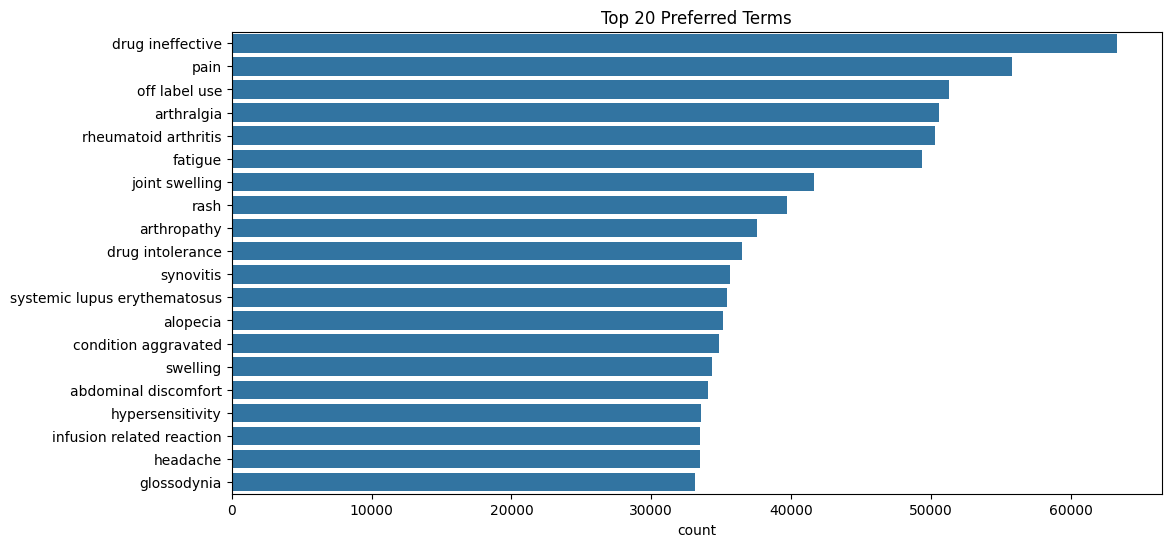

In [68]:
# Plot the distribution of the top 20 preferred terms
plt.figure(figsize=(12, 6))
sns.countplot(y=pts, order=pd.Series(pts).value_counts().index[:20])
plt.title('Top 20 Preferred Terms')
plt.show()

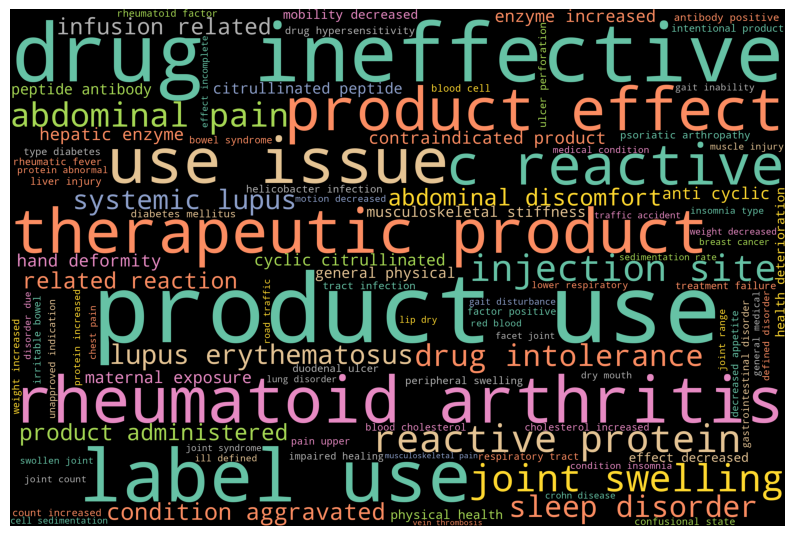

In [69]:
from wordcloud import WordCloud
# Word cloud 
word_list = ' '.join(pts)
wordcloud_pts = WordCloud(
    width=3000,
    height=2000,
    colormap='Set2',
    max_words=100,
    random_state=42
).generate(word_list)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_pts)
plt.axis('off')
plt.show()

In [70]:
data_4 = data_3.explode('pt', ignore_index=True)

In [71]:
# Save data
data_4.to_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned.csv', index=False)